In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder as le
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import plotly.express as px

### 🔍 Data Preparation  
This section loads the dataset, checks its structure, and encodes categorical features into numeric form using `LabelEncoder`.


In [78]:
df = pd.read_csv('Breast_Cancer.csv')

In [79]:
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [81]:
df.shape

(4024, 16)

In [82]:
df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


<Axes: >

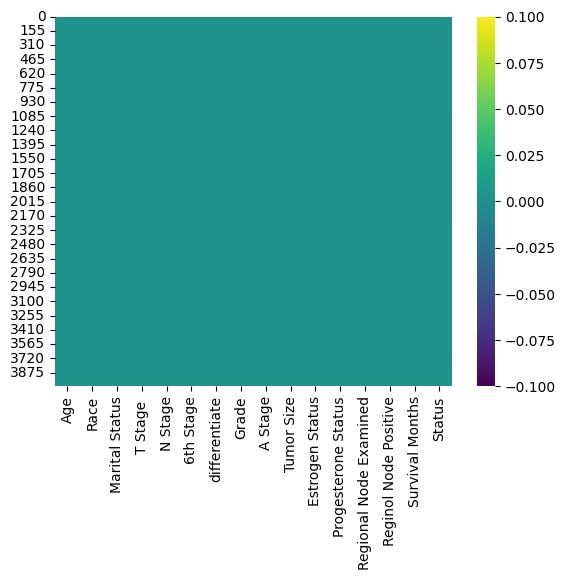

In [83]:
sns.heatmap(df.isnull(), cmap = 'viridis')

<Axes: xlabel='Status'>

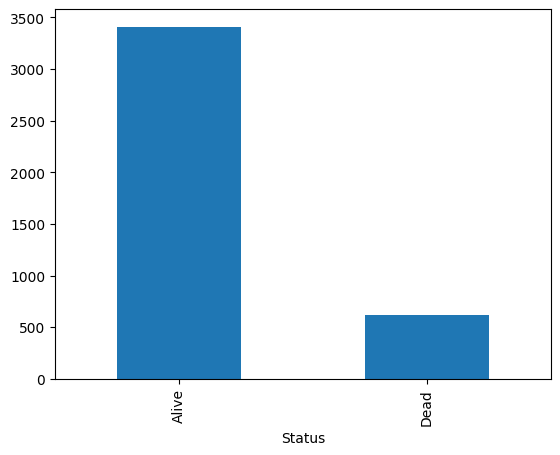

In [84]:
df.Status.value_counts().plot.bar()

In [85]:
object_data = df.select_dtypes('object').columns
for col in object_data:
  df[col] = le().fit_transform(df[col])

### 📊 Correlation Analysis  
Here we analyze feature correlations and drop highly correlated ones to avoid multicollinearity in the models.


In [86]:
def define_corr(df):
  corr = df.corr()
  corr_matrix = corr.abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
  return to_drop
feat_to_drop = define_corr(df)

In [87]:
X = df.drop('Status', axis = 1)
y = df['Status']

### 🧪 Oversampling (Class Balancing)  
We apply `RandomOverSampler` to balance the dataset, ensuring equal representation of each class for fair training.


In [88]:
X_ros, y_ros = RandomOverSampler(random_state = 41).fit_resample(X, y)

### 🧠 Model & Feature Set Setup  
This block defines a dictionary of machine learning models and prepares two feature sets: full and reduced (with correlated features removed).

---

In [89]:
features_all = X_ros.columns.tolist()
features_reduced = [f for f in features_all if f not in feat_to_drop]
feature_sets = {
    'all_features': features_all,
    'reduced_features': features_reduced
}

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [91]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier()
}


### 🚀 Model Cross-Validation  
We train each model using 5-fold cross-validation and collect ROC AUC metrics for both feature sets.


In [100]:
all_results = []
step = 0
for feat_name, feat_cols in feature_sets.items():
    X_subset = X_ros[feat_cols]

    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        scores = cross_val_score(pipeline, X_subset, y_ros, cv=5, scoring='roc_auc')

        result = {
            'Feature Set': feat_name,
            'Model': model_name,
            'Mean ROC AUC': np.mean(scores),
            'Std ROC AUC': np.std(scores),
            'Step': step
        }

        all_results.append(result)
        step += 1


In [105]:
df_results = pd.DataFrame(all_results)
df_results['Label'] = df_results['Model'] + ' (' + df_results['Feature Set'] + ')'
df_results.sort_values(by=['Mean ROC AUC'], ascending=[False])

,Feature Set,Model,Mean ROC AUC,Std ROC AUC,Step,Label
1,all_features,Random Forest,0.999303,0.000838,1,Random Forest (all_features)
6,reduced_features,Random Forest,0.998776,0.000475,6,Random Forest (reduced_features)
3,all_features,XGBoost,0.987864,0.002036,3,XGBoost (all_features)
8,reduced_features,XGBoost,0.984696,0.002462,8,XGBoost (reduced_features)
4,all_features,Gradient Boosting,0.912905,0.005485,4,Gradient Boosting (all_features)
9,reduced_features,Gradient Boosting,0.910284,0.004025,9,Gradient Boosting (reduced_features)
2,all_features,SVC,0.899972,0.005597,2,SVC (all_features)
7,reduced_features,SVC,0.891695,0.005539,7,SVC (reduced_features)
0,all_features,Logistic Regression,0.863482,0.005187,0,Logistic Regression (all_features)
5,reduced_features,Logistic Regression,0.860435,0.005106,5,Logistic Regression (reduced_features)


### 📈 ROC AUC Animation During XGBoost Training  
This part visualizes the evolution of the ROC AUC metric over each boosting iteration while training an `XGBClassifier`.


In [106]:
fig = px.bar(df_results,
             x="Mean ROC AUC",
             y="Label",
             color="Feature Set",
             orientation='h',
             animation_frame="Step",
             range_x=[0.5, 1.0],
             title="Model Performance (ROC AUC) Over Time")

fig.update_layout(xaxis_title="Mean ROC AUC", yaxis_title="Model",
                  height=600)

fig.show()


In [125]:
from xgboost import XGBClassifier

X_subset = X_ros[features_all]
y_subset = y_ros


In [126]:
model = XGBClassifier(
    n_estimators=100,
    eval_metric='auc',
    use_label_encoder=False
)

model.fit(
    X_subset,
    y_subset,
    eval_set=[(X_subset, y_subset)],
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [127]:
eval_result = model.evals_result()
roc_auc_values = eval_result['validation_0']['auc']


In [130]:
df_all = []

for i in range(len(roc_auc_values)):
    for j in range(i + 1):
        df_all.append({
            'Iteration': j,
            'ROC AUC': roc_auc_values[j],
            'Frame': i
        })

df_anim = pd.DataFrame(df_all)


In [148]:
fig = px.line(df_anim,
              x='Iteration',
              y='ROC AUC',
              animation_frame='Frame',
              title='ROC AUC by iteration for XGBClassifier',
              range_y=[0.5, 20])

fig.update_layout(
    xaxis_title="Iteration",
    yaxis_title="ROC AUC",
    showlegend=False,
    yaxis_range=[min(roc_auc_values) * 0.99, max(roc_auc_values) * 1.01],
    xaxis_range=[0, len(roc_auc_values)],
)
fig.show()